In [1]:
import os
import copy

import numpy as np

from nems import Model, visualization

In [2]:
# load data (download if necessary)
signals_dir = "/auto/data/nems_db/recordings"
basename = 'TAR010c-18-2.npz'
datafile = os.path.join(signals_dir, basename)

if not os.path.exists(datafile):
    print(f"Need to download demo data file {datafile}")
    import requests
    prefix = 'https://s3-us-west-2.amazonaws.com/nemspublic/sample_data/'
    uri = prefix + basename
    r = requests.get(uri, stream=True)
    with open(datafile, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
    
d = np.load(datafile)

cellid = 'TAR010c-18-2'
fs = 100
X_est=d['X_est']
Y_est=d['Y_est']
X_val=d['X_val']
Y_val=d['Y_val']

In [3]:
# normalize stimulus peak to 1
X_norm = X_est.max()
X_est /= X_norm
X_val /= X_norm

In [4]:
modelspec = 'wc.18x1-fir.15x1-relu.1.o.s'
model0 = Model.from_keywords(modelspec)
model0.sample_from_priors();

## Scipy backend fit

In [5]:
model_sci = copy.deepcopy(model0)

print('Backend: scipy, Fitting without NL ...')
model_sci.layers[-1].skip_nonlinearity=True
model_sci=model_sci.fit(input=X_est, target=Y_est, backend='scipy',
          fitter_options={'cost_function': 'nmse', 'options': {'maxiter': 50}})

print('Backend: scipy, Now fitting with NL ...')
model_sci.layers[-1].skip_nonlinearity=False
model_sci=model_sci.fit(input=X_est, target=Y_est, backend='scipy',
          fitter_options={'cost_function': 'nmse', 'options': {'maxiter': 100}})

Backend: scipy, Fitting without NL ...
Epoch 0
        Iteration 0, error is: 1.00322638...
        Iteration 5, error is: 0.99729086...
        Iteration 10, error is: 0.96339283...
        Iteration 15, error is: 0.94782112...
        Iteration 20, error is: 0.92198351...
        Iteration 25, error is: 0.91444497...
        Iteration 30, error is: 0.90958056...
        Iteration 35, error is: 0.90910686...
        Iteration 40, error is: 0.90883536...
        Iteration 45, error is: 0.90875196...
Fit successful: False
Status: 1
Message: STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Backend: scipy, Now fitting with NL ...
Epoch 0
        Iteration 0, error is: 1.37688231...
        Iteration 5, error is: 0.90443882...
        Iteration 10, error is: 0.90265586...
Fit successful: False
Status: 2
Message: ABNORMAL_TERMINATION_IN_LNSRCH


prediction correlation: 0.570


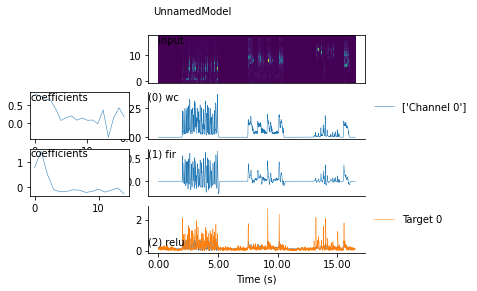

In [6]:
prediction = model_sci.predict(X_val)
cc = np.corrcoef(prediction[:,0], Y_val[:,0])[0,1]
print(f'prediction correlation: {cc:.3f}')
visualization.model.plot_model_with_parameters(
        model_sci, X_val, target=Y_val, sampling_rate=fs);

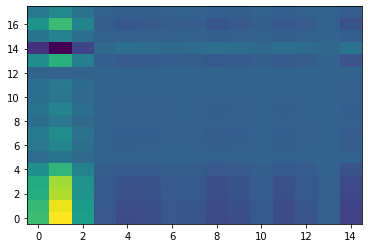

In [7]:
visualization.model.simple_strf(model_sci);

## TF backend fit

In [5]:
model_tf = copy.deepcopy(model0)

fitter_options = {'early_stopping_delay': 100, 'early_stopping_patience': 150,
                  'early_stopping_tolerance': 5e-4, 'validation_split': 0.0, 
                  'learning_rate': 1e-3,  'epochs': 500}

print('Backend: tf, Fitting without NL ...')
model_tf.layers[-1].skip_nonlinearity=True
model_tf=model_tf.fit(input=np.expand_dims(X_est, axis=0),
          target=np.expand_dims(Y_est, axis=0), backend='tf',
          fitter_options=fitter_options, batch_size=None)

print('Backend: tf, Now fitting with NL ...')
model_tf.layers[-1].skip_nonlinearity=False
fitter_options['learning_rate'] = 1e-4
model_tf=model_tf.fit(input=np.expand_dims(X_est, axis=0),
          target=np.expand_dims(Y_est, axis=0), backend='tf',
          fitter_options=fitter_options, batch_size=None)

Backend: tf, Fitting without NL ...


2022-08-25 11:20:38.231812: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-25 11:20:38.869703: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7285 MB memory:  -> device: 0, name: GeForce GTX 1080, pci bus id: 0000:65:00.0, compute capability: 6.1


TF model built...
Model: "UnnamedModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 49500, 18)]       0         
                                                                 
 wc (WeightChannelsTF)       (None, 49500, 1)          18        
                                                                 
 fir (FiniteImpulseResponseT  (None, 49500, 1)         15        
 F)                                                              
                                                                 
 relu (RectifiedLinearTF)    (None, 49500, 1)          3         
                                                                 
Total params: 36
Trainable params: 35
Non-trainable params: 1
_________________________________________________________________
None


2022-08-25 11:20:39.820025: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 7605
2022-08-25 11:20:39.822624: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-25 11:20:39.824650: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.2.89, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


Epoch 1/500
1/1 [==============================] - 0s 258ms/step - loss: 0.1905
Epoch 2/500
1/1 [==============================] - 0s 5ms/step - loss: 0.1901
Epoch 3/500
1/1 [==============================] - 0s 6ms/step - loss: 0.1896
Epoch 4/500
1/1 [==============================] - 0s 6ms/step - loss: 0.1892
Epoch 5/500
1/1 [==============================] - 0s 7ms/step - loss: 0.1888
Epoch 6/500
1/1 [==============================] - 0s 6ms/step - loss: 0.1883
Epoch 7/500
1/1 [==============================] - 0s 6ms/step - loss: 0.1879
Epoch 8/500
1/1 [==============================] - 0s 6ms/step - loss: 0.1875
Epoch 9/500
1/1 [==============================] - 0s 6ms/step - loss: 0.1871
Epoch 10/500
1/1 [==============================] - 0s 6ms/step - loss: 0.1867
Epoch 11/500
1/1 [==============================] - 0s 6ms/step - loss: 0.1862
Epoch 12/500
1/1 [==============================] - 0s 6ms/step - loss: 0.1858
Epoch 13/500
1/1 [==============================] - 0s 6ms/

1/1 [==============================] - 0s 8ms/step - loss: 0.1583
Epoch 105/500
1/1 [==============================] - 0s 9ms/step - loss: 0.1582
Epoch 106/500
1/1 [==============================] - 0s 8ms/step - loss: 0.1580
Epoch 107/500
1/1 [==============================] - 0s 7ms/step - loss: 0.1578
Epoch 108/500
1/1 [==============================] - 0s 9ms/step - loss: 0.1576
Epoch 109/500
1/1 [==============================] - 0s 7ms/step - loss: 0.1574
Epoch 110/500
1/1 [==============================] - 0s 8ms/step - loss: 0.1572
Epoch 111/500
1/1 [==============================] - 0s 9ms/step - loss: 0.1570
Epoch 112/500
1/1 [==============================] - 0s 8ms/step - loss: 0.1569
Epoch 113/500
1/1 [==============================] - 0s 7ms/step - loss: 0.1567
Epoch 114/500
1/1 [==============================] - 0s 9ms/step - loss: 0.1565
Epoch 115/500
1/1 [==============================] - 0s 7ms/step - loss: 0.1563
Epoch 116/500
1/1 [==============================] - 0

1/1 [==============================] - 0s 8ms/step - loss: 0.1464
Epoch 207/500
1/1 [==============================] - 0s 8ms/step - loss: 0.1463
Epoch 208/500
1/1 [==============================] - 0s 8ms/step - loss: 0.1463
Epoch 209/500
1/1 [==============================] - 0s 8ms/step - loss: 0.1462
Epoch 210/500
1/1 [==============================] - 0s 8ms/step - loss: 0.1461
Epoch 211/500
1/1 [==============================] - 0s 8ms/step - loss: 0.1461
Epoch 212/500
1/1 [==============================] - 0s 7ms/step - loss: 0.1460
Epoch 213/500
1/1 [==============================] - 0s 7ms/step - loss: 0.1460
Epoch 214/500
1/1 [==============================] - 0s 9ms/step - loss: 0.1459
Epoch 215/500
1/1 [==============================] - 0s 8ms/step - loss: 0.1459
Epoch 216/500
1/1 [==============================] - 0s 8ms/step - loss: 0.1458
Epoch 217/500
1/1 [==============================] - 0s 8ms/step - loss: 0.1458
Epoch 218/500
1/1 [==============================] - 0

1/1 [==============================] - 0s 8ms/step - loss: 0.1432
Epoch 309/500
1/1 [==============================] - 0s 8ms/step - loss: 0.1432
Epoch 310/500
1/1 [==============================] - 0s 8ms/step - loss: 0.1432
Epoch 311/500
1/1 [==============================] - 0s 8ms/step - loss: 0.1432
Epoch 312/500
1/1 [==============================] - 0s 7ms/step - loss: 0.1432
Epoch 313/500
1/1 [==============================] - 0s 7ms/step - loss: 0.1432
Epoch 314/500
1/1 [==============================] - 0s 7ms/step - loss: 0.1432
Epoch 315/500
1/1 [==============================] - 0s 8ms/step - loss: 0.1432
Epoch 316/500
1/1 [==============================] - 0s 7ms/step - loss: 0.1432
Epoch 317/500
1/1 [==============================] - 0s 8ms/step - loss: 0.1431
Epoch 318/500
1/1 [==============================] - 0s 7ms/step - loss: 0.1431
Epoch 319/500
1/1 [==============================] - 0s 8ms/step - loss: 0.1431
Epoch 320/500
1/1 [==============================] - 0

1/1 [==============================] - 0s 8ms/step - loss: 0.1427
Epoch 411/500
1/1 [==============================] - 0s 7ms/step - loss: 0.1427
Epoch 412/500
1/1 [==============================] - 0s 7ms/step - loss: 0.1427
Epoch 413/500
1/1 [==============================] - 0s 7ms/step - loss: 0.1427
Epoch 414/500
1/1 [==============================] - 0s 8ms/step - loss: 0.1427
Epoch 415/500
1/1 [==============================] - 0s 8ms/step - loss: 0.1427
Epoch 416/500
1/1 [==============================] - 0s 7ms/step - loss: 0.1427
Epoch 417/500
1/1 [==============================] - 0s 7ms/step - loss: 0.1427
Epoch 418/500
1/1 [==============================] - 0s 8ms/step - loss: 0.1427
Epoch 419/500
1/1 [==============================] - 0s 8ms/step - loss: 0.1427
Epoch 420/500
1/1 [==============================] - 0s 7ms/step - loss: 0.1427
Epoch 421/500
1/1 [==============================] - 0s 7ms/step - loss: 0.1427
Epoch 422/500
1/1 [==============================] - 0

2022-08-25 11:20:45.522750: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://26cec2c8-fd32-4cfe-9d21-723fc98a6f4f/assets
TF model built...
Model: "UnnamedModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 49500, 18)]       0         
                                                                 
 wc (WeightChannelsTF)       (None, 49500, 1)          18        
                                                                 
 fir (FiniteImpulseResponseT  (None, 49500, 1)         15        
 F)                                                              
                                                                 
 relu (RectifiedLinearTF)    (None, 49500, 1)          3         
                                                                 
Total params: 36
Trainable params: 35
Non-trainable params: 1
_________________________________________________________________
None
Epoch 1/500
1/1 

1/1 [==============================] - 0s 7ms/step - loss: 0.1426
Epoch 91/500
1/1 [==============================] - 0s 7ms/step - loss: 0.1426
Epoch 92/500
1/1 [==============================] - 0s 7ms/step - loss: 0.1426
Epoch 93/500
1/1 [==============================] - 0s 8ms/step - loss: 0.1426
Epoch 94/500
1/1 [==============================] - 0s 7ms/step - loss: 0.1426
Epoch 95/500
1/1 [==============================] - 0s 8ms/step - loss: 0.1426
Epoch 96/500
1/1 [==============================] - 0s 7ms/step - loss: 0.1426
Epoch 97/500
1/1 [==============================] - 0s 7ms/step - loss: 0.1426
Epoch 98/500
1/1 [==============================] - 0s 7ms/step - loss: 0.1426
Epoch 99/500
1/1 [==============================] - 0s 8ms/step - loss: 0.1426
Epoch 100/500
1/1 [==============================] - 0s 7ms/step - loss: 0.1426
Epoch 101/500
1/1 [==============================] - 0s 8ms/step - loss: 0.1426
Epoch 102/500
1/1 [==============================] - 0s 11ms/st

1/1 [==============================] - 0s 8ms/step - loss: 0.1426
Epoch 193/500
1/1 [==============================] - 0s 8ms/step - loss: 0.1426
Epoch 194/500
1/1 [==============================] - 0s 8ms/step - loss: 0.1426
Epoch 195/500
1/1 [==============================] - 0s 7ms/step - loss: 0.1426
Epoch 196/500
1/1 [==============================] - 0s 7ms/step - loss: 0.1426
Epoch 197/500
1/1 [==============================] - 0s 7ms/step - loss: 0.1426
Epoch 198/500
1/1 [==============================] - 0s 7ms/step - loss: 0.1426
Epoch 199/500
1/1 [==============================] - 0s 8ms/step - loss: 0.1426
Epoch 200/500
1/1 [==============================] - 0s 8ms/step - loss: 0.1426
Epoch 201/500
1/1 [==============================] - 0s 8ms/step - loss: 0.1426
Epoch 202/500
1/1 [==============================] - 0s 8ms/step - loss: 0.1426
Epoch 203/500
1/1 [==============================] - 0s 8ms/step - loss: 0.1426
Epoch 204/500
1/1 [==============================] - 0

/home/svd/bin/miniconda3/envs/nems/lib/python3.9/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/svd/bin/miniconda3/envs/nems/lib/python3.9/site-packages/numpy/lib/function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


prediction correlation: nan


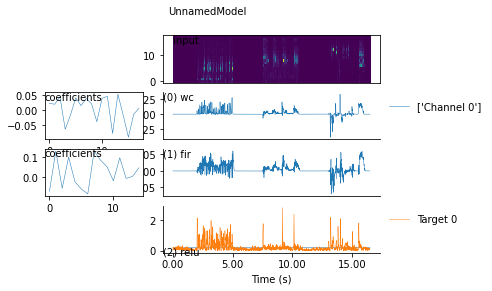

In [6]:
prediction = model_tf.predict(X_val)
cc = np.corrcoef(prediction[:,0], Y_val[:,0])[0,1]
print(f'prediction correlation: {cc:.3f}')
visualization.model.plot_model_with_parameters(
        model_tf, X_val, target=Y_val, sampling_rate=fs);

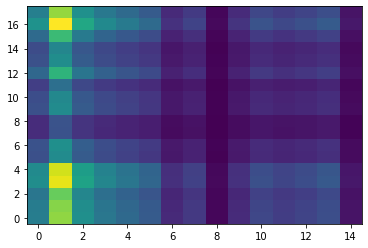

In [10]:
visualization.model.simple_strf(model_tf);